**Download dataset :**
To download a dataset using the Kaggle API in Colab, you are required to upload your Kaggle credentials(kaggle.json file) into the Colab environment.(available at /EMTCNN)

In [1]:
!mkdir ~/.kaggle/
! cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d davidvazquezcic/yawn-dataset
!kaggle datasets download -d serenaraju/yawn-eye-dataset-new


 95% 16.0M/16.9M [00:01<00:00, 13.8MB/s]
100% 16.9M/16.9M [00:01<00:00, 9.05MB/s]
 99% 159M/161M [00:09<00:00, 20.5MB/s]
100% 161M/161M [00:09<00:00, 17.3MB/s]


Downloading second eye dataset from roboflow

In [3]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="Jwvs69UMwWPJoR2ypOpV")
project = rf.workspace("phoenix-bpovw").project("drowsiness-detection-n9uj5")
dataset = project.version(4).download("tensorflow")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 76.3 MB/s eta 0:00:00
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=26e8ac3bc403fc3fe15254953453ee7b7d5cde5410a3324ee8eb25d10fc0ad0c
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.1.0
    Uninstalling pyparsing-3.1.0:
      Su

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Drowsiness-Detection-4 in tensorflow:: 100%|██████████| 777/777 [00:00<00:00, 1031.92it/s]


In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image
import cv2
import os
import zipfile
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [5]:
# Unzip the dataset

local_zip = '/content/yawn-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('yawn-dataset')
zip_ref.close()

local_zip = '/content/yawn-eye-dataset-new.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('eye-dataset')
zip_ref.close()


After labeling the images using the functions provided in the "labelling_dataset" file, we proceed to organize them into separate directories based on their class ("close" for label 0 and "open" for label 1). This allows for efficient management and analysis of the images.


ensure to upload the "label.txt" file into the Colab environment.(available at /EMTCNN)

In [7]:
import os
import shutil

def copy_images_to_class_directories(input_file, source_directory, destination_directory):
    with open(input_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            line = line.strip()
            image_path, class_label = line.split(',')
            class_label = int(class_label)

            # Get the image filename from the full path
            image_filename = os.path.basename(image_path)

            # Create the destination directory based on the class label
            if class_label == 0:
                class_directory = os.path.join(destination_directory, 'close')
            elif class_label == 1:
                class_directory = os.path.join(destination_directory, 'open')
            else:
                print(f"Invalid class label found for image: {image_filename}. Skipping...")
                continue

            # Check if the class directory exists, if not, create it
            if not os.path.exists(class_directory):
                os.makedirs(class_directory)

            # Copy the image from the source to the destination directory
            shutil.copy(os.path.join(source_directory, image_filename), class_directory)


input_file = "/content/labels.txt"  # Replace with the actual name of your .txt file
source_directory = "/content/Drowsiness-Detection-4/train"  # Replace with the source directory containing images
destination_directory = "/content/eye-dataset-2"  # Replace with the destination directory for the copied images

copy_images_to_class_directories(input_file, source_directory, destination_directory)


Loading dataset

In [1]:
import os
def get_file_paths(directory):
    file_paths = []
    for root, directories, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
    return file_paths

In [2]:
close_eye = get_file_paths('/content/eye-dataset/dataset_new/train/Closed') + get_file_paths('/content/eye-dataset-2/close')
open_eye = get_file_paths('/content/eye-dataset/dataset_new/train/Open') + get_file_paths('/content/eye-dataset-2/open')
yawn = get_file_paths('/content/yawn-dataset/yawn')
no_yawn = get_file_paths('/content/yawn-dataset/no yawn')

Samples from dataset

In [3]:
def show_images(image_paths,labels):
  fig, axes = plt.subplots(2, 2, figsize=(10, 8))

  # Plot each image with its label
  for i, ax in enumerate(axes.flat):
      img = Image.open(image_paths[i])
      ax.imshow(img)  # Replace 'images[i]' with the actual image data
      ax.set_title(labels[i])  # Replace 'labels[i]' with the corresponding label
      ax.axis('off')


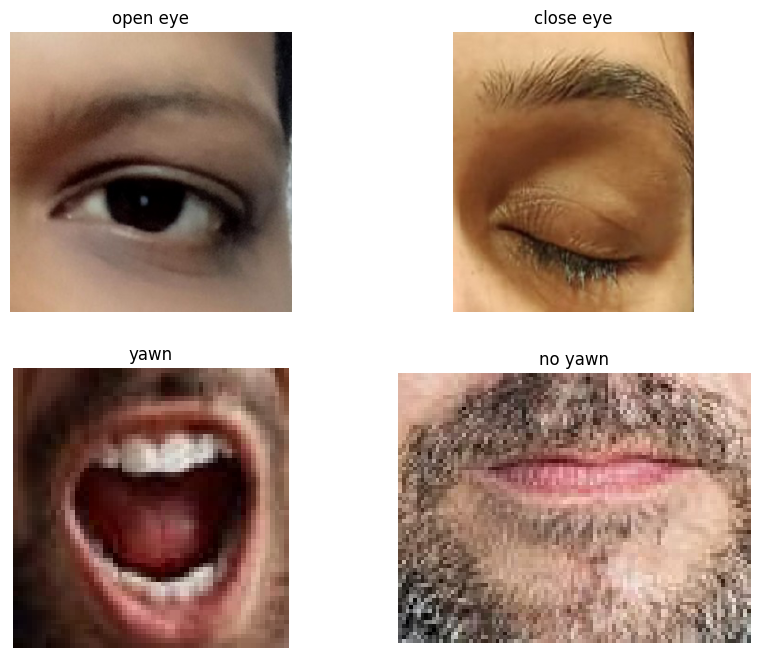

In [6]:
show_images([open_eye[120],close_eye[129],yawn[321],no_yawn[721]]
            ,['open eye','close eye','yawn','no yawn'])

performing a comparison of the dataset's different class sizes.

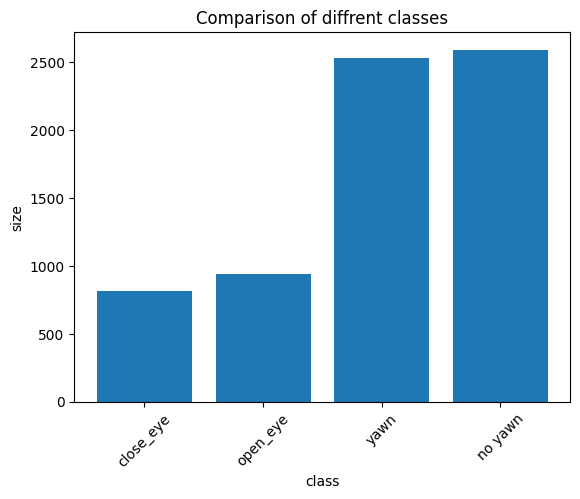

In [7]:
# Replace these lists with your own data
list_labels = ['close_eye','open_eye','yawn','no yawn']
list_lengths = [len(close_eye), len(open_eye),len(yawn),len(no_yawn)]

# Create a bar chart
plt.bar(list_labels, list_lengths)

# Add labels and title
plt.xlabel('class')
plt.ylabel('size')
plt.xticks(rotation=45)
plt.title('Comparison of diffrent classes')

# Show the plot
plt.show()

load data into dataframe

In [8]:
df_eye_open = pd.DataFrame({'Path':open_eye,'eye_open':np.ones(len(open_eye)),'eye_close':np.zeros(len(open_eye)),'yawn':np.zeros(len(open_eye)),'no_yawn':np.zeros(len(open_eye))})
df_eye_close = pd.DataFrame({'Path':close_eye,'eye_open':np.zeros(len(close_eye)),'eye_close':np.ones(len(close_eye)),'yawn':np.zeros(len(close_eye)),'no_yawn':np.zeros(len(close_eye))})
df_mouth_open = pd.DataFrame({'Path':yawn,'eye_open':np.zeros(len(yawn)),'eye_close':np.zeros(len(yawn)),'yawn':np.ones(len(yawn)),'no_yawn':np.zeros(len(yawn))})
df_moth_close = pd.DataFrame({'Path':no_yawn,'eye_open':np.zeros(len(no_yawn)),'eye_close':np.zeros(len(no_yawn)),'yawn':np.zeros(len(no_yawn)),'no_yawn':np.ones(len(no_yawn))})


In [9]:
df = pd.concat([df_eye_open,df_eye_close,df_mouth_open,df_moth_close])
df = df.sample(frac=1) #shuffling dataset
df = df.reset_index()

Ensuring that all images possess three color channels,and removing annomalies






In [10]:
image_channels = [np.array(Image.open(df.iloc[row]['Path'])).shape[-1] for row in range(len(df))]

In [11]:
color_channel_anomalies = [c for c in range(len(image_channels)) if image_channels[c]!=3]

In [12]:
color_channel_anomalies

[150, 1437]

In [13]:
df.drop(color_channel_anomalies, inplace=True)

In [14]:
df.shape

(6871, 6)

split dataset to train and test

In [15]:
train_df ,test_df = train_test_split(df,test_size=0.1)

model architecture

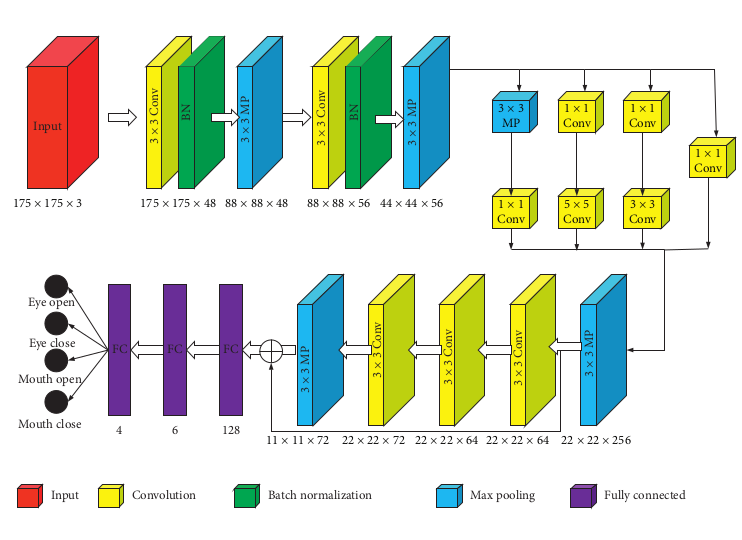

Define model

In [16]:
Input = keras.Input(shape=(175, 175, 3))
conv1 = layers.Conv2D(filters=48, kernel_size=3, strides=1, padding='same')(Input)
BN1 = layers.BatchNormalization()(conv1)
MP1 = layers.MaxPool2D(pool_size=(3, 3), strides=2)(BN1)
conv2 = layers.Conv2D(filters=56, kernel_size=3, strides=1, padding='same')(MP1)
BN2 = layers.BatchNormalization()(conv2)
MP2 = layers.MaxPool2D(pool_size=(3, 3), strides=2)(BN2)

MP3 = layers.MaxPool2D(pool_size=(3, 3), strides=1, padding='same')(MP2)
conv4 = layers.Conv2D(filters=56, kernel_size=1, strides=1, padding='same')(MP3)
conv5 = layers.Conv2D(filters=56, kernel_size=1, strides=1, padding='same')(MP2)
conv6 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same')(MP2)
conv7 = layers.Conv2D(filters=64, kernel_size=1, strides=1, padding='same')(MP2)
conv8 = layers.Conv2D(filters=64, kernel_size=5, strides=1, padding='same')(conv5)
conv9 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(conv6)
combined = layers.concatenate([conv9, conv8, conv7, conv4])
MP4 = layers.MaxPool2D(pool_size=(3, 3), strides=2)(combined)

# Downsample MP4 to match spatial dimensions of MP5_input
MP4_downsampled = layers.Conv2D(filters=72, kernel_size=3, strides=2)(MP4)

conv10 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(MP4)
conv11 = layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(conv10)
conv12 = layers.Conv2D(filters=72, kernel_size=3, strides=1, padding='same')(conv11)
MP5_input = layers.MaxPool2D(pool_size=(3, 3), strides=2)(conv12)

# Adjust the spatial dimensions of MP5_input to match MP4_downsampled
#MP5_input_adjusted = layers.Conv2D(filters=248, kernel_size=1, strides=1, padding='same')(MP5_input)

# Residual block
residual = layers.Add()([MP4_downsampled, MP5_input])
residual = layers.Activation('relu')(residual)

flatten = layers.Flatten()(residual)
Dense1 = layers.Dense(128, activation='relu')(flatten)
Dense2 = layers.Dense(6, activation='relu')(Dense1)
Dense3 = layers.Dense(4, activation='softmax')(Dense2)

# Create the model
model = keras.Model(Input,Dense3)

model summary

In [40]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 175, 175, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 175, 175, 48  1344        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_4 (BatchNo  (None, 175, 175, 48  192        ['conv2d_24[0][0]']              
 rmalization)                   )                                                           

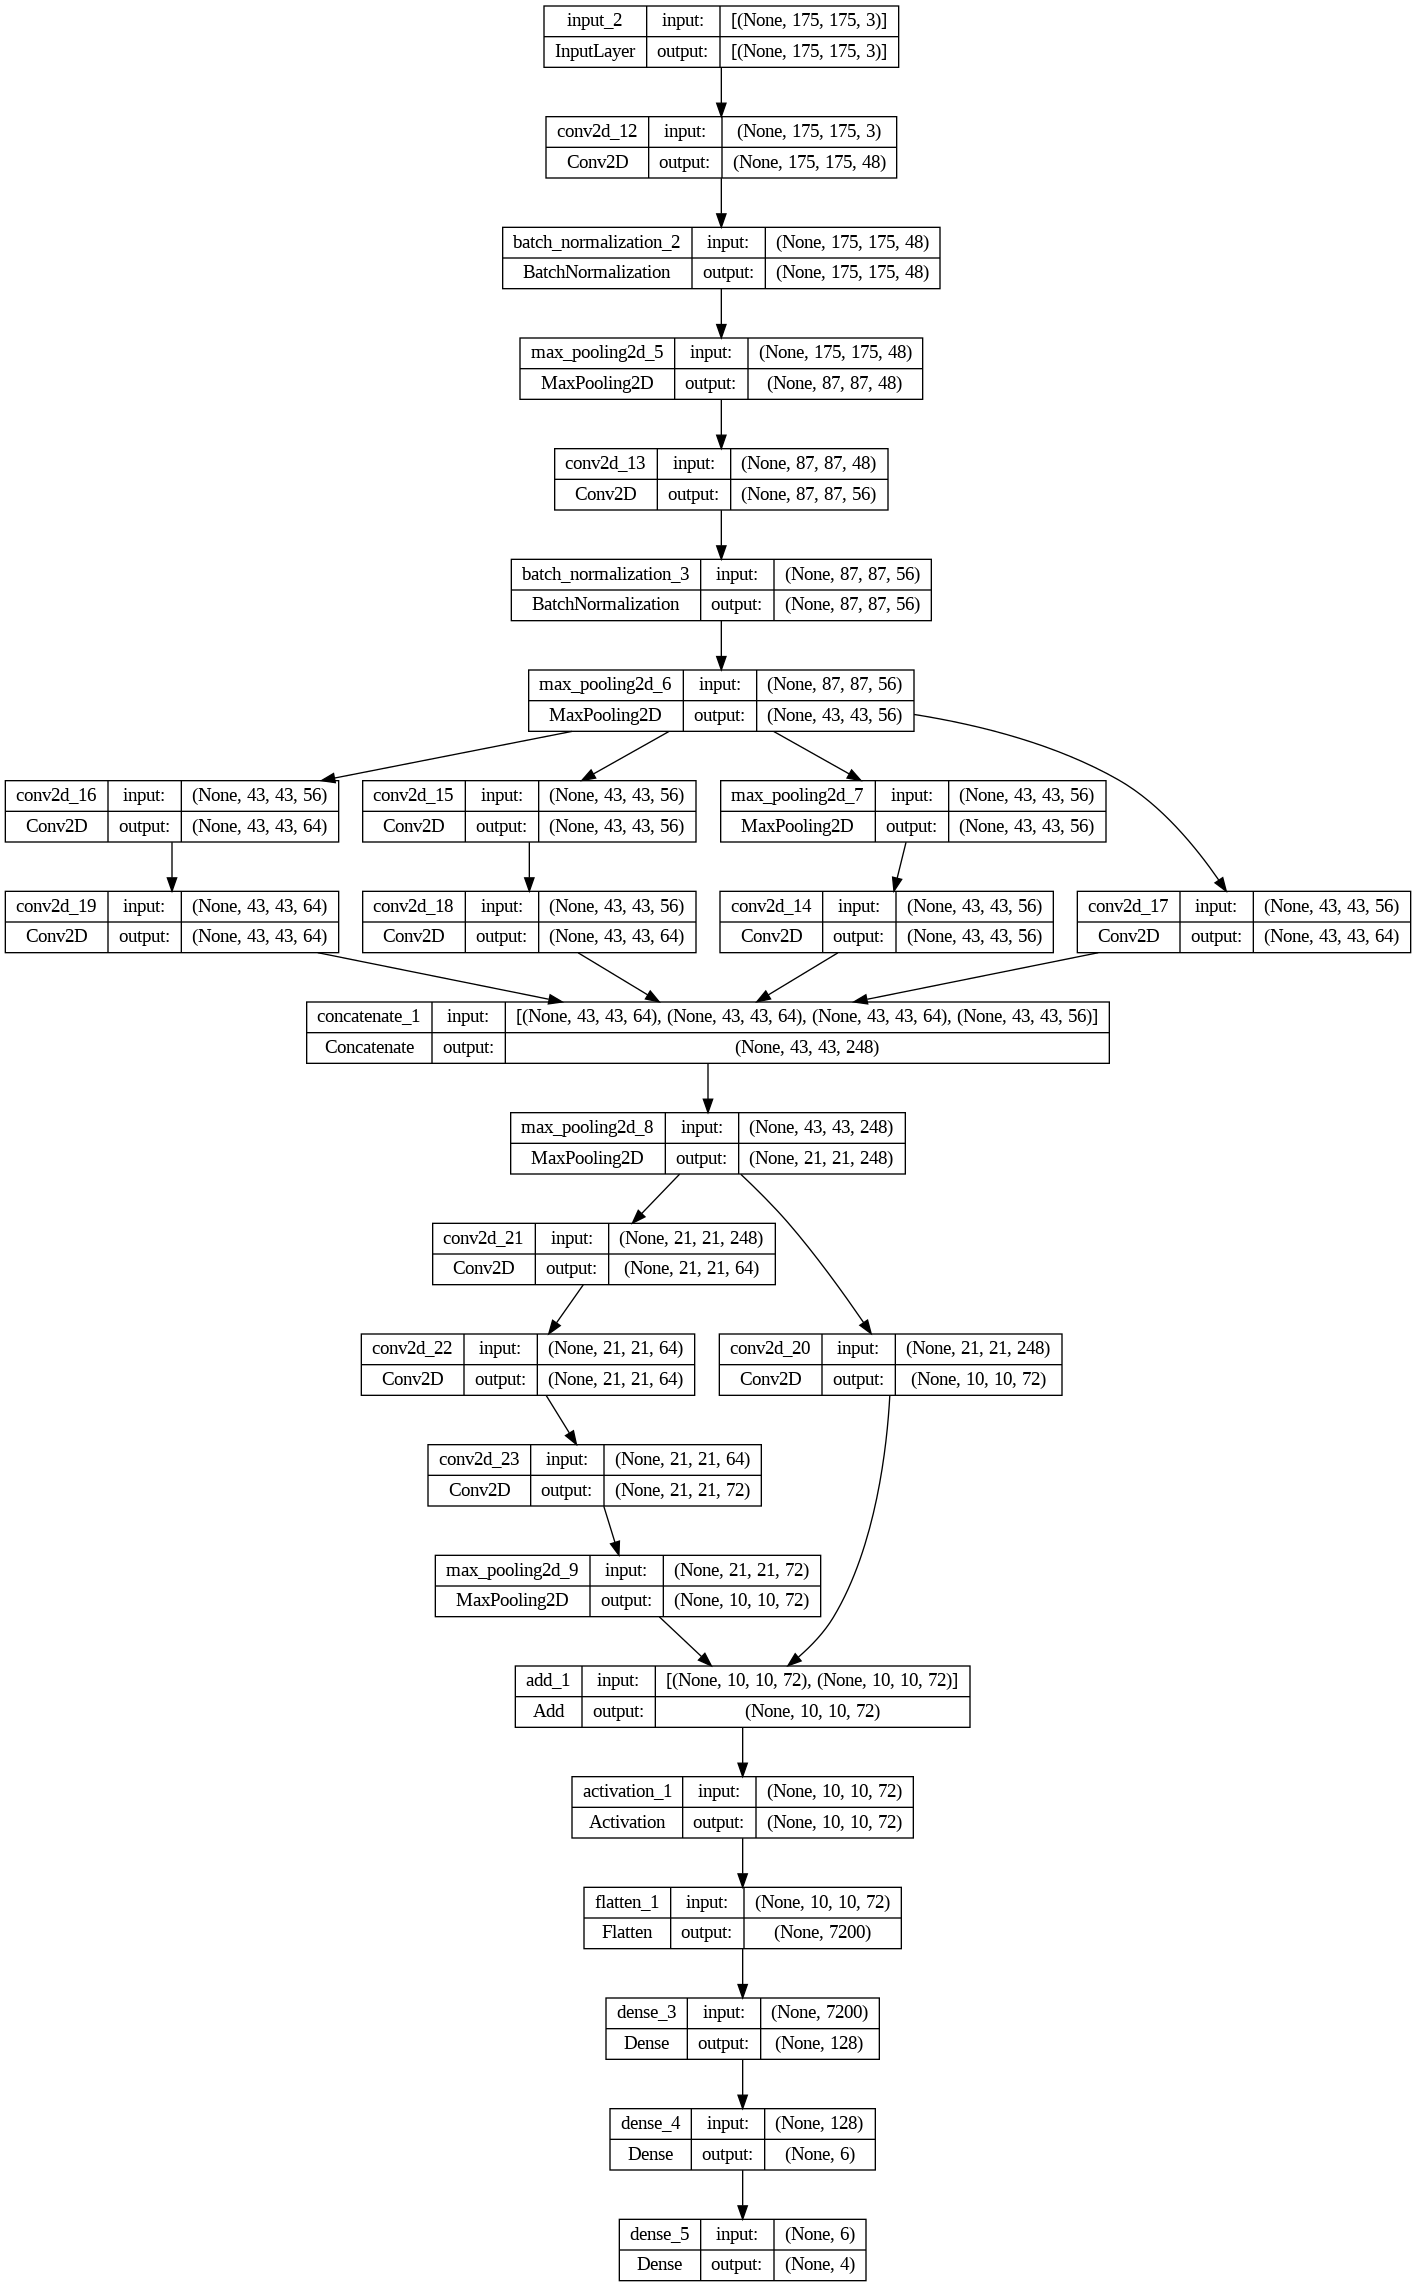

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


**compiling model,**<br>Cross-entropy loss is a suitable choice for this classification tasks because it optimizes accurate class probabilities, handles multiclass problems, and is compatible with gradient-based optimization methods.

In [17]:
import tensorflow as tf
model.compile(loss= 'categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.0001) ,metrics= ['accuracy'])

The following function takes a batch of images as input,reads image, converts each image to grayscale, resizes them, and normalizes their pixel values.

In [18]:
def preprocess_batch_images(df) :
  images=[]
  for row in range(len(df)) :
      images.append(np.array(Image.open(df.iloc[row]["Path"]).resize((175,175)))/255)
  return np.array(images)

creating datagenerator for training on batches

In [19]:
def data_generator(data, batch_size):
    num_samples = len(data)
    num_batches = num_samples // batch_size

    while True:
        data = data.sample(frac=1)
        for i in range(num_batches):
            batch_data = data.iloc[i * batch_size : (i + 1) * batch_size]

            batch_labels = batch_data[['eye_open','eye_close','yawn','no_yawn']].values

            batch_features = preprocess_batch_images(batch_data[['Path']])

            yield batch_features, batch_labels

data augmentation and train on batches



In [20]:
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
datagen = ImageDataGenerator(
    rotation_range=20,         # Random rotation in the range [-20, 20] degrees
    width_shift_range=0.1,     # Random horizontal shift by 10% of the image width
    height_shift_range=0.1,    # Random vertical shift by 10% of the image height
    shear_range=0.2,           # Random shear transformation in the range [-20, 20] degrees
    zoom_range=0.2,            # Random zoom between 80% and 120% of the original size
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Fill mode for newly created pixels during transformations
)
batch_size = 256
num_epochs = 30

losses=[]
accuracies=[]
train_generator = data_generator(train_df, batch_size)
steps_per_epoch = len(train_df) // batch_size

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    progress_bar = tqdm(range(steps_per_epoch), desc=f"Loss: 0.0000", leave=False)
    # Training loop
    for step in progress_bar:

        X_batch , y_batch = next(train_generator)
        # Apply data augmentation to the current batch
        augmented_images, augmented_labels = next(datagen.flow(X_batch, y_batch, batch_size=batch_size))
        loss, accuracy = model.train_on_batch(augmented_images, augmented_labels)

        progress_bar.set_description("Loss: {} - accuracy: {}".format(loss,accuracy))
    losses.append(loss)
    accuracies.append(accuracy)


Epoch 1/30


Epoch 2/30


Epoch 3/30


Epoch 4/30


Epoch 5/30


Epoch 6/30


Epoch 7/30


Epoch 8/30


Epoch 9/30


Epoch 10/30


Epoch 11/30


Epoch 12/30


Epoch 13/30


Epoch 14/30


Epoch 15/30


Epoch 16/30


Epoch 17/30


Epoch 18/30


Epoch 19/30


Epoch 20/30


Epoch 21/30


Epoch 22/30


Epoch 23/30


Epoch 24/30


Epoch 25/30


Epoch 26/30


Epoch 27/30


Epoch 28/30


Epoch 29/30


Epoch 30/30


Plotting loss and accuracy for diffrent stages of training

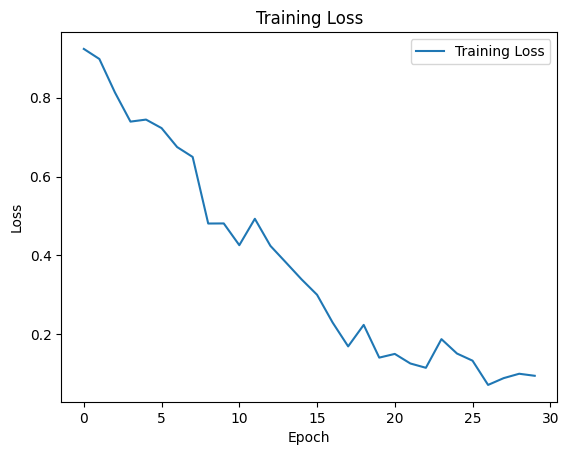

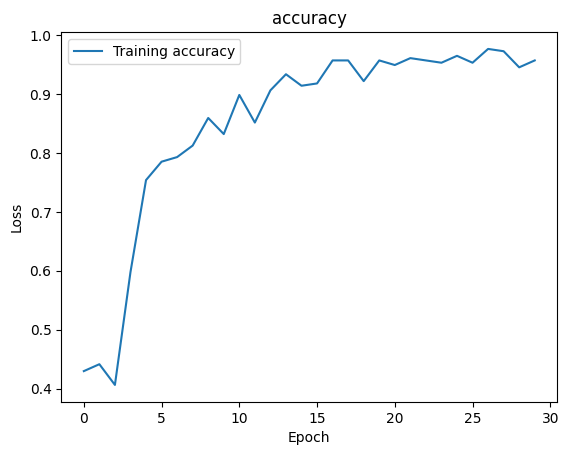

In [21]:
# Plot training loss
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Loss')
plt.show()

plt.plot(accuracies, label='Training accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('accuracy')
plt.show()


Saving model weights

In [22]:
model.save_weights('model_weights.hdf5')

loading model weights<br>
*Note:* please upload model weights(model_weights.hdf5) file into colab

In [23]:
model.load_weights('model_weights.hdf5')

accuracy on test set

In [24]:
test_generator = data_generator(test_df, len(test_df))
X_test,y_test = next(test_generator)

In [25]:
print('accuracy for test set:',model.evaluate(X_test,y_test)[1])

22/22 [==============================] - 2s 44ms/step - loss: 0.0867 - accuracy: 0.9724
accuracy for test set: 0.9723837375640869


test accuracy for each class

In [26]:
def calculate_class_accuracy(y_true, y_pred, class_labels):
    num_classes = len(class_labels)
    class_accuracy = {}

    for i in range(num_classes):
        class_name = class_labels[i]
        true_mask = y_true[:, i] == 1
        pred_mask = y_pred[:, i] == 1

        true_positive = np.sum(y_true[true_mask] == y_pred[true_mask])
        false_positive = np.sum(y_true[~true_mask] != y_pred[~true_mask])
        false_negative = np.sum(y_true[true_mask] != y_pred[true_mask])

        accuracy = true_positive / (true_positive + false_positive + false_negative)
        class_accuracy[class_name] = accuracy

    return class_accuracy

In [27]:
y_pred = model.predict(X_test)
predicted_class = (y_pred == np.max(y_pred, axis=1, keepdims=True)).astype(int)

22/22 [==============================] - 1s 24ms/step


In [28]:
calculate_class_accuracy(y_test,predicted_class,['open_eye','close_eye','yawn','no_yawn'])

{'open_eye': 0.909952606635071,
 'close_eye': 0.8944444444444445,
 'yawn': 0.9638783269961977,
 'no_yawn': 0.9631782945736435}

confusion matrix

In [29]:


def plot_confusion_matrix(y_true, y_pred, class_labels):
    cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(len(class_labels), len(class_labels)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()


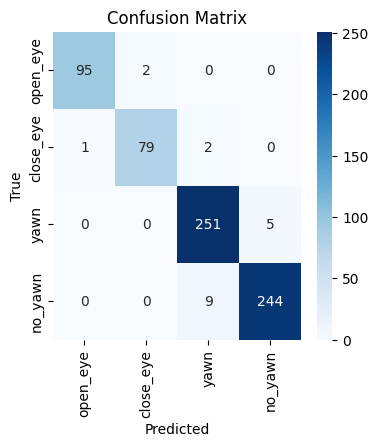

In [30]:
plot_confusion_matrix(y_test,predicted_class,['open_eye','close_eye','yawn','no_yawn'])